# [0] 개요
- 자전거 대여 수요 예측
- 날짜, 계절, 근무일, 날씨, 체감온도, 풍속 등등 데이터를 활용하여 대여 수량 예측
- 유형 : 회귀
- 평가지표 : RMSE (L => 로그 => 타겟값 분포 체크 기본 => 필요시 정규분포처리)
- 기타
    - 2014.5 ~ 2015.5 : 대회기간 1년
    - 2011~12년 -> 데이터 2년
        - 훈련데이터는 매달 1일 ~ 19일
        - 테스트데이트 20일 ~ 말일
            - 일별 기준 데이터는 사용하기 애매함
    - 지역 워싱턴DC
        - 자전거 무상 임대

# [1] 데이터 준비

In [4]:
import os
import pandas as pd
import numpy as np
path = '/content/drive/MyDrive/ASAC/Python 머신러닝/Q3'
train = pd.read_csv(os.path.join(path,'train.csv'))
test = pd.read_csv(os.path.join(path,'test.csv'))
submission = pd.read_csv(os.path.join(path, 'sampleSubmission.csv'))

train.shape, test.shape, submission.shape

((10886, 12), (6493, 9), (6493, 2))

In [5]:
print(train.columns) # casua, registered 피처 제거
print(test.columns) # casua, registered 피처 누락
print(submission.columns) # 날짜별 예측한 대여수.

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')
Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')
Index(['datetime', 'count'], dtype='object')


In [6]:
# 데이터 확인
'''
datetime : 1시간 단위, 년, 월, 일, 시, 분, 초 => 파생변수로 요일, 분기, 반기 분, 초는 의미 없다 => 주기성
season : 계절, 4개값 예상, 월 3개를 묶으면 계절로 구성 가능, 순서형 or 명목형 가능
holiday : 공휴일(0,1) => 이진형
workingday : 근무일(0,1) => 이진형
weather : 날씨(1~4) => 1:맑음, 2:약간흐림, 3:약간의 눈/비 4:폭풍/천둥/번개
temp : 실제온도, 연속형
atemp : 체감온도, 연속형
humidity : 상대습도, 연속형
windspeed : 풍속, 연속형
count : 연속형, 종속변수, 타겟값으로 예측해야할 값임
'''



train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


#[1] 데이터 시각화 EDA
- 모델 구축시 필요한 데이터 가공을 위한 탐색, 피처엔지니어링 전략 수립
- 추가적 파생변수 체크

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

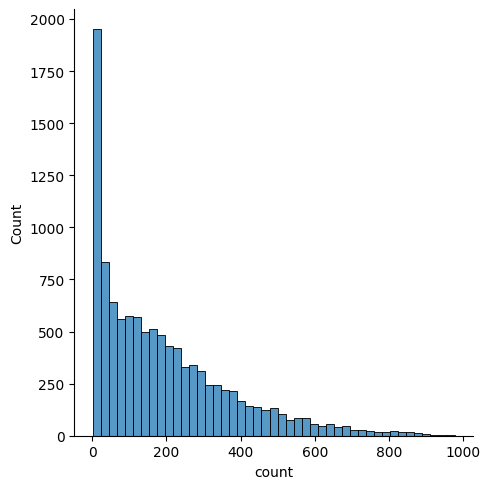

In [11]:
sns.displot(train['count']);
# 해석
# X축 count, y축은 카운트 값의 빈도(총개수) => 같은 값이 나올 수 있다
# 추세로 보면 왼쪽으로 쏠려있다(치우처져있다) => 편향되어있다, 0인근에 몰려있다
# 좋은 모델은 모델을 만들기 위해 -> 데이터를 정규븐포에 근사하게(따라가게) 조정할 필요가 있다
# 변환처리 => 평가지표가 rmsLe => 로그처리로 되지 않을까 접근
# 편향된 데이터 => 로그변환 => 정규분포에 가깝게 변환한다
# 예측 => exp() 함수로 변환 => 원래값

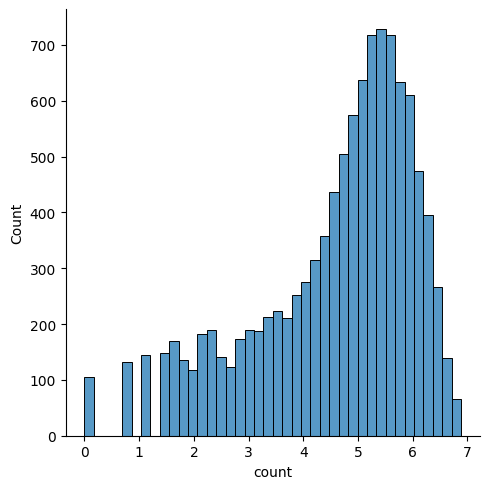

In [12]:
sns.displot(np.log(train['count']));
# 정교하지 않지만 정규분포 (평균0, 표준편차 1, 좌우대칭형)비슷하게 구분

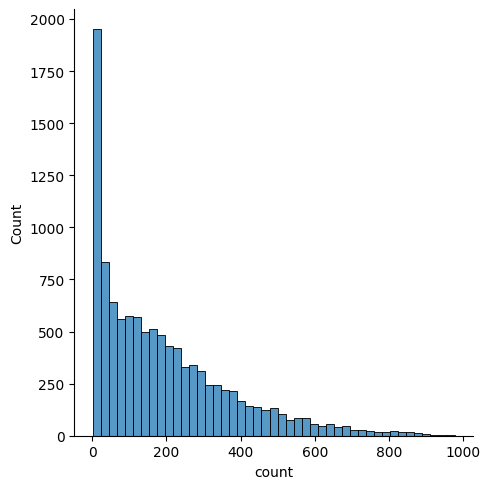

In [13]:
# 원래 형태
sns.displot(np.exp(np.log(train['count'])))

In [ ]:
# 년, 월, 일, 시, 분, 초 추출 파생변수 생성
train['year'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[0])
train['month'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[1])
train['day'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[2])

train['hour']= train['datetime'].apply(lambda x: x.split()[1].split(':')[0])
train['minute']= train['datetime'].apply(lambda x: x.split()[1].split(':')[1])
train['second']= train['datetime'].apply(lambda x: x.split()[1].split(':')[2])

train.iloc[:,-7:].head()

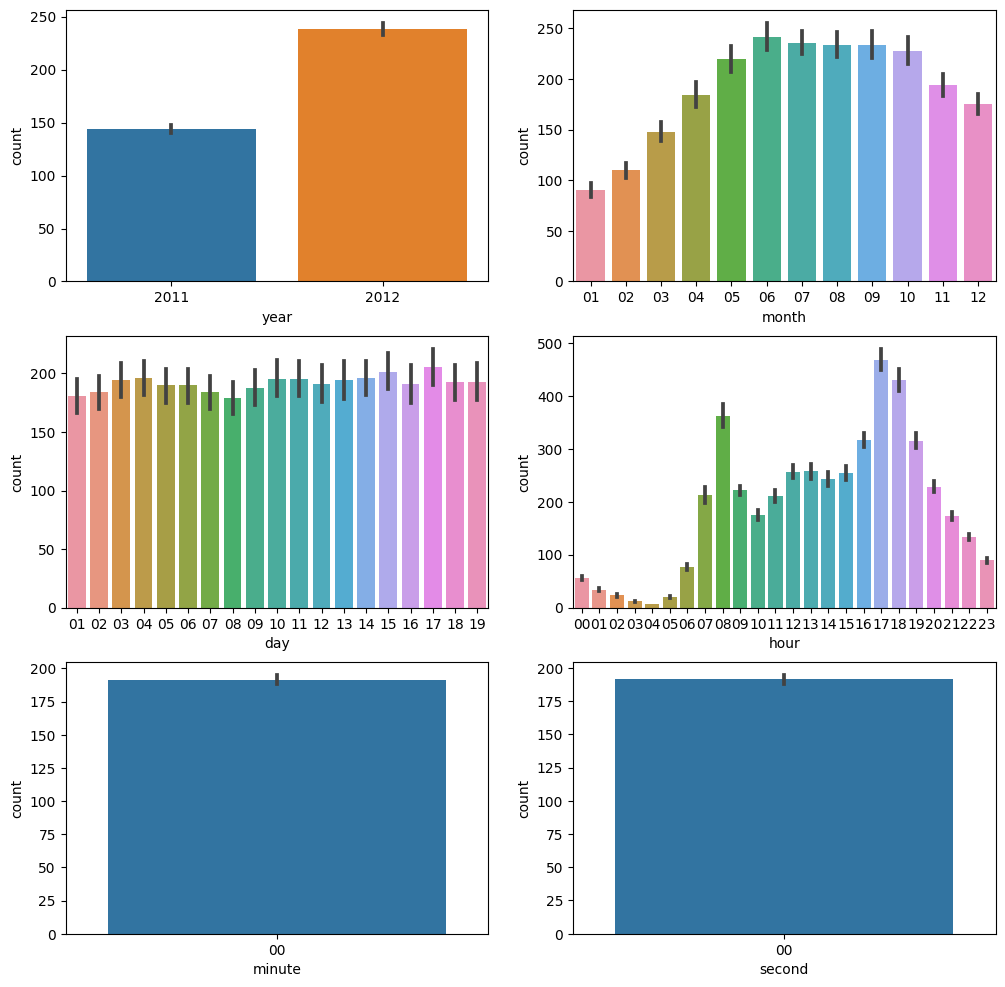

In [18]:
# 시각화를 통한 EDA
fig, axes = plt.subplots(nrows = 3, ncols = 2)
fig.set_size_inches(12,12)

# 바차트 (피처대 타겟)
sns.barplot(x = 'year', y = 'count', data = train, ax = axes[0,0])
# year 기준에서는 2012년도에 더 성장, 차이가 존재, 바 가운데 막대기(오차범위)가 다른 바를 침범할 정도로 긴가? 적용해도 2011년도와는 차이가 존재 => 학습 사용

sns.barplot(x = 'month', y = 'count', data = train, ax = axes[0,1])
# 6월 ~ 10월 이용자 11월부터 저점
# 오차범위는 6~10월까지는 서로 약하게 겹쳐있다 => 변별력이 떨어짐, 이외에 11월 ~ 5월까지는 구분이 잘됨 => 학습에 도움이 될 수 있음
# 대체값 => season으로 대체 가능할듯?

sns.barplot(x = 'day', y = 'count', data = train, ax = axes[1,0])
# 오차범위가 서로 많이 겹쳐있다 => 구분하기 어렵다
# 20 ~ 말일까지는 데이터가 없다 (테스트 데이터로 이동)

sns.barplot(x = 'hour', y = 'count', data = train, ax = axes[1,1])
# 출근시간대 (7~8)시 피크값 등장
# 퇴근시간대 (17~18)시 피크 사용량이 나옴
# 시간별로 구분이 잘 됨 => 사용합시다

sns.barplot(x = 'minute', y = 'count', data = train, ax = axes[2,0])
sns.barplot(x = 'second', y = 'count', data = train, ax = axes[2,1])
# 분,초단위로는 구분이 되어 있지 않다. 사용하지 않는다!

plt.show()

## 근무/휴일, 계절, 날씨

- 범주형데이터
- 박스플롯
    - X축은 피처
    - y축

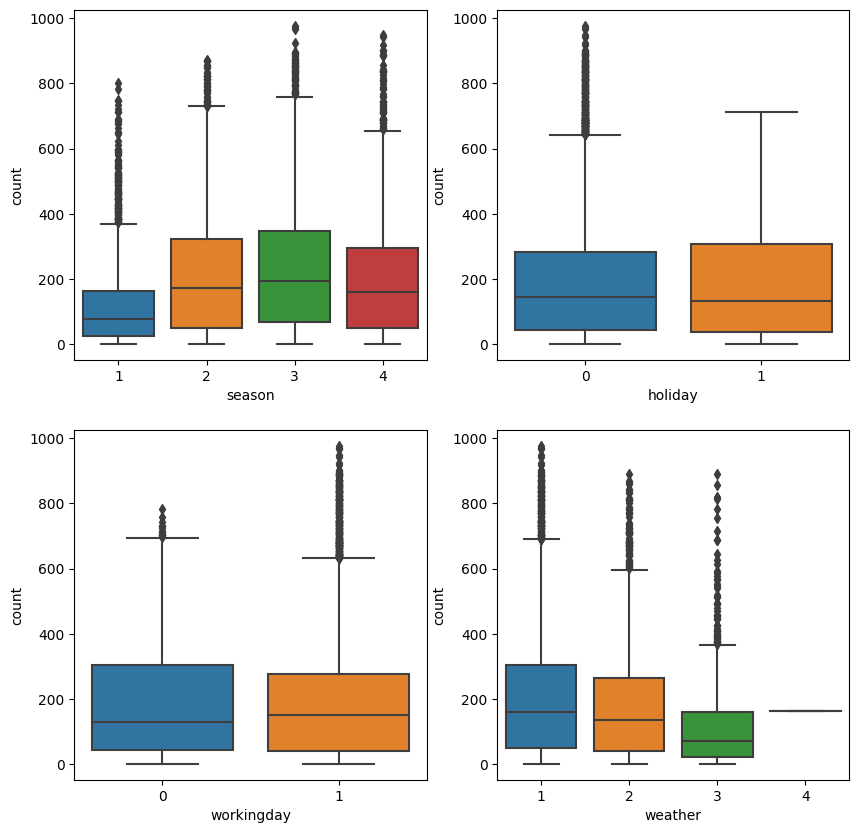

In [19]:
# 시각화를 통한 EDA
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(10,10)

# 박스플롯
sns.boxplot(x = 'season', y = 'count', data = train, ax = axes[0,0])

sns.boxplot(x = 'holiday', y = 'count', data = train, ax = axes[0,1])

sns.boxplot(x = 'workingday', y = 'count', data = train, ax = axes[1,0])

sns.boxplot(x = 'weather', y = 'count', data = train, ax = axes[1,1])

plt.show()

## 시간대비 정답, 주요 피처간 관계

- 포인트 플롯을 통한 시각화
    - 범주형 데이터와 수치형 데이터간의 평균과 신뢰구간을 점과 선으로 표현
    - x축 : 시간, y축 : 정답(대여수), hue(주요피처)

In [25]:
import calendar
from datetime import datetime
datetime.strptime('2023-09-11', '%Y-%m-%d').weekday()

0

In [27]:
# 요일 피차
import calendar
from datetime import datetime
# calendar.day_name 0:mon ~ 6: sun
train['weekday'] = train['datetime'].apply(lambda x: calendar.day_name[datetime.strptime(x.split()[0], '%Y-%m-%d').weekday()])
train['weekday']

0         Saturday
1         Saturday
2         Saturday
3         Saturday
4         Saturday
           ...    
10881    Wednesday
10882    Wednesday
10883    Wednesday
10884    Wednesday
10885    Wednesday
Name: weekday, Length: 10886, dtype: object

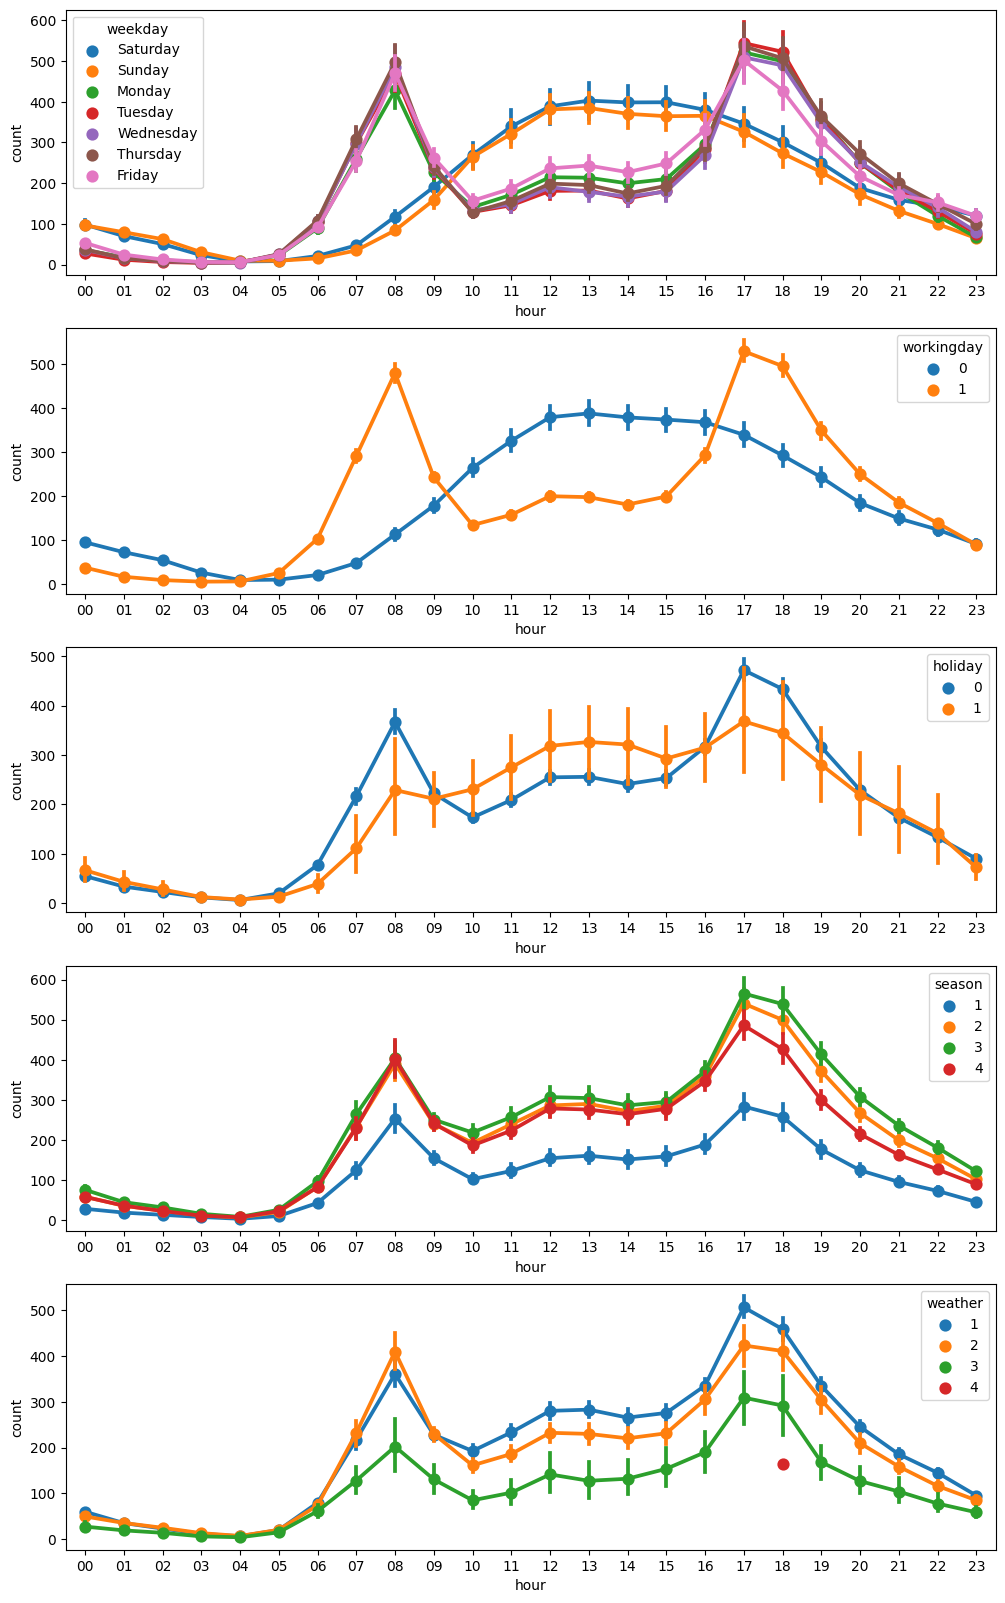

In [33]:
fig, axes = plt.subplots(nrows = 5)
fig.set_size_inches(12,20)

# holiday, workingday, weekday(생성, 요일), season, weather
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'weekday', ax = axes[0])
# 주5일근무 기준, 주말(토,일)추세선 / 평일(월~금) 추세선이 상이하다 => 주말 대비 평일 데이터라면 구분이 어려움
# 추가로 휴일, 근무일도 확인해봅시다
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'workingday', ax = axes[1])
# 0일때 값은 요일별 평일 포인트플롯과 동일한 추세를 가진다 => 상관관계가 높아보임
# 1일때 값은 0일때 추세선에 오차범위에 겹침 -> 학습에 딱히 필요 없을듯
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'holiday', ax = axes[2])
# 확연한 구분, 요일의 평일과 주말 추세선과 거의 동일 => 상관관계 높을듯
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'season', ax = axes[3])
# 계절 단위에서는 추울 때 비교적 적게 사용
# 나머지 계절은 비슷함
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'weather', ax = axes[4])
# 아웃라이어 제거(4) 후 사용
# 추세는 비슷하나, 데이터가 구분된다. 오차범위가 거의 겹치지 않는다 => 사용가능성이 큼

plt.show()

## 연속형 데이터 시각화
- 회귀선+산점(포)도 : regplot
- 상관관계 체크
- 온도, 체감온도, 습도,풍속

In [35]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'weekday'],
      dtype='object')

<Axes: xlabel='temp', ylabel='count'>

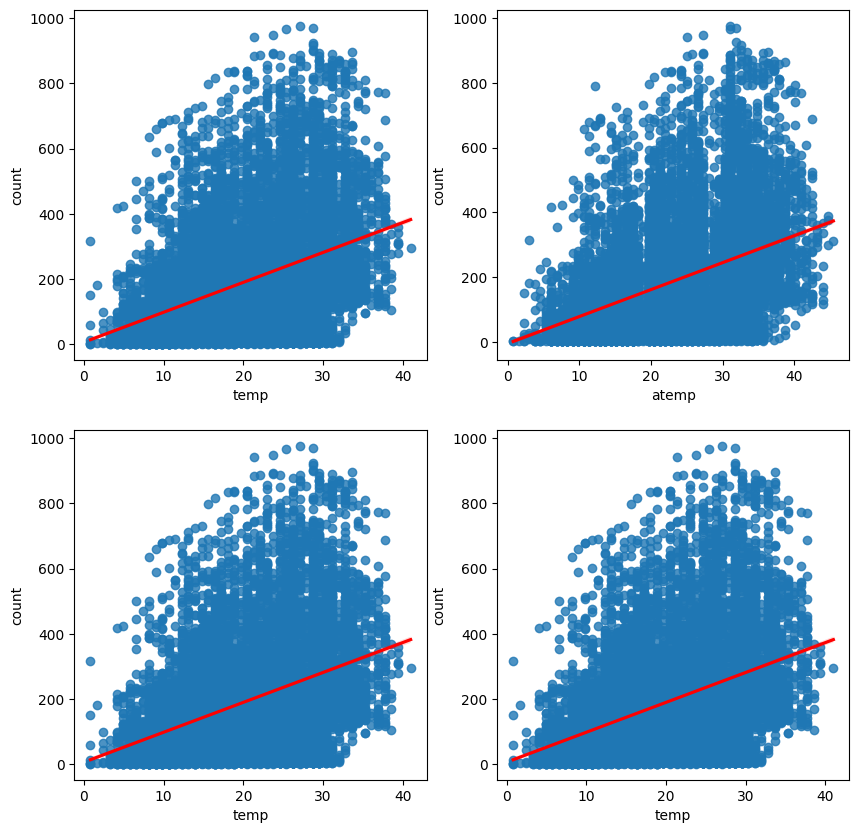

In [37]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(10,10)

sns.regplot(x = 'temp', y = 'count', data = train, ax = axes[0,0], line_kws = {'color':'red'})

sns.regplot(x = 'atemp', y = 'count', data = train, ax = axes[0,1], line_kws = {'color':'red'})
# 온도, 체감온도 데이터의 회귀선은 거의 정답에 대해 동일함. 비례적인 모습
# 상관관계가 높을 것으로 예상됨 => 하나만 간다


sns.regplot(x = 'temp', y = 'count', data = train, ax = axes[1,0], line_kws = {'color':'red'})

sns.regplot(x = 'temp', y = 'count', data = train, ax = axes[1,1], line_kws = {'color':'red'})

## 수치 데이터간 상관관계
- 히트맵 + 수치표시
- 다중회귀, 강한상관관계 발견시 VIF(다중공산성 문제 체크) -> 여러 피처보다는 중요 피처 1개 사용이 더 적절함
    - 온도, 체감온도 => 상관관계가 높다
    - 둘다 사용하면  VIF 상승, 하나만 사용하면 이 문제 해결
    - 신뢰성 획득

In [38]:
corr_values = train[['temp','atemp','humidity','windspeed','count']].corr()
corr_values

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


<Axes: >

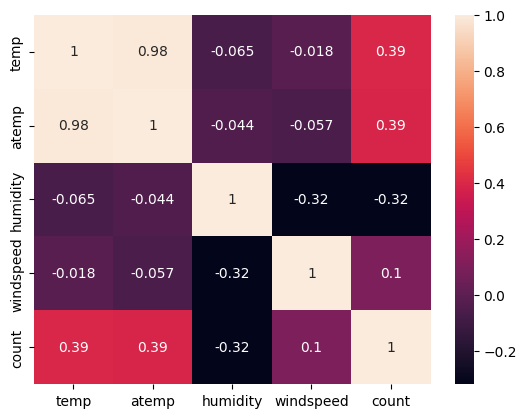

In [39]:
sns.heatmap(corr_values, annot=True)
# temp 와 atemp는 강한 상관관계, 독립변수간 강한 상관관계 0.9를 초과, 거의 1에 육박 => 1개만 학습에 사용
# humidity와 windspeed

#[2] 피처엔지니어링 전략

- 타겟값 : 로그처리
    - 예측후 exp()처리하여 결과값 셑ㅇ

- 피처
    - datetime에서의 파생 피처
        - year 사용
        - hour 사용
        - month 보류, season으로 대체 가능할지도
        - 나머지 제거
        - day 제거 (20~이후 데이터 X)


    - temp, atemp 중 하나만 사용
    - windspeed 제거(데이터 오류 예상)
    - 훈련 데이터에만 존재하는 피처
        - casual, registered 제거
        - 테스트 데이터에 누락
    
- 이상치 제거
    - weather에서 값 4 제거 => 데이터 자체를 삭제

- 결측치
    - 해당없음

- 피처 스케일링
    - 베이스 라인 이후로 판단

- 피처 분포
    - 미체크
    - 추세선은 체크했음

## 피처엔지니어링

- 학습에 사용된 최종 피처 확정, 훈련용, 테스트용 등등 확정
- 필요에 따라서는 데이터를 합쳐서 인코딩 처리도 가능

In [45]:
train = pd.read_csv(os.path.join(path,'train.csv'))
test = pd.read_csv(os.path.join(path,'test.csv'))
submission = pd.read_csv(os.path.join(path, 'sampleSubmission.csv'))

train.shape, test.shape, submission.shape

((10886, 12), (6493, 9), (6493, 2))

In [46]:
# 이상치 제거 => 훈련용 1개, 테스트용 2개
train = train[train['weather'] != 4 ]
train.shape

(10885, 12)

#### 데이터 통합
- 데이터 인코딩 처리시 한번에 처리하기 위함
- 범주형 대상

In [47]:
train_test = pd.concat([train, test], axis = 0, ignore_index = True)
train_test.shape

(17378, 12)

In [48]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17378 entries, 0 to 17377
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17378 non-null  object 
 1   season      17378 non-null  int64  
 2   holiday     17378 non-null  int64  
 3   workingday  17378 non-null  int64  
 4   weather     17378 non-null  int64  
 5   temp        17378 non-null  float64
 6   atemp       17378 non-null  float64
 7   humidity    17378 non-null  int64  
 8   windspeed   17378 non-null  float64
 9   casual      10885 non-null  float64
 10  registered  10885 non-null  float64
 11  count       10885 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 1.6+ MB


#### 파생 피처 생성
- 년도, 시간, 요일

In [49]:
# 2011:0, 2012:1
train_test['year'] = train_test['datetime'].apply(lambda x: 0 if '2011' == x.split()[0].split('-')[0] else 1)
#train_test['month'] = train_test['datetime'].apply(lambda x: x.split()[0].split('-')[1])
#train_test['day'] = train_test['datetime'].apply(lambda x: x.split()[0].split('-')[2])

# 값 그대로 0 ~ 23
train_test['hour']= train_test['datetime'].apply(lambda x:x.split()[1].split(':')[0])

train_test['weekday'] = train_test['datetime'].apply(lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d').weekday())

train_test.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,0,00,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,0,01,5


### 피처제거 (썬택)
- EDA를 통해 제거 대상 선정
- 다중회귀
    - 후진 제거법
        -뒤에 있는 칼럼부터 제거 -> ㅏ학습 -> 예측 -> 평가 반복
    - 전진 선택법
        - 앞에 있는 칼럼부터 선택 -> 학습 -> 예측 -> 평가 반복
    - 모든 조합의 결과로 가장 좋은 피처를 선택
    - 피처의 순서
        - 순서의 조합
- 학습중(알고리즘 내부에서)
    - L1규제를통해서 학습계쑤를 0으로 만들어서 피처제거

In [50]:
train_test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'hour', 'weekday'],
      dtype='object')

In [51]:
# 제거 대상 선정
feats_drop = ['casual', 'registered', 'datetime', 'windspeed',  'atemp']
train_test = train_test.drop(feats_drop, axis = 1)
train_test.head(1)

,season,holiday,workingday,weather,temp,humidity,count,year,hour,weekday
0,1,0,0,1,9.84,81,16.0,0,00,5


In [52]:
train_test.info()
# 카운트 피처(종속변수)
# 모든 데이터는 수치형으로 조정 완료

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17378 entries, 0 to 17377
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17378 non-null  int64  
 1   holiday     17378 non-null  int64  
 2   workingday  17378 non-null  int64  
 3   weather     17378 non-null  int64  
 4   temp        17378 non-null  float64
 5   humidity    17378 non-null  int64  
 6   count       10885 non-null  float64
 7   year        17378 non-null  int64  
 8   hour        17378 non-null  object 
 9   weekday     17378 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 1.3+ MB


### 데이터 나누기
- 정답 결측을 통해서 분할 처리

In [53]:
a = pd.DataFrame({
    't':[1,2,np.nan,4]
})
a

,t
0,1.0
1,2.0
2,NaN
3,4.0


In [65]:
# 결측이 있는 데이터 추출 => df
a[pd.isnull(a.t)]

,t
2,NaN


In [66]:
X = train_test[~pd.isnull(train_test['count'])]
X_sub = train_test[pd.isnull(train_test['count'])] # submission


X.shape, X_sub.shape

((10885, 10), (6493, 10))

In [68]:
# 훈련용 데이터 최종정리
y = X['count']
X = X.drop(['count'], axis = 1)
X_sub = X_sub.drop(['count'], axis = 1) # 단, 정답은 추출하지 않는다(모두 결측)

## 훈련용, 테스트 데이터 분할

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8163, 9), (2722, 9), (8163,), (2722,))

In [72]:
# y_train -> log 처리
log_y = np.log(y_train)

## 평가지표 점검, 필요시 함수 생성

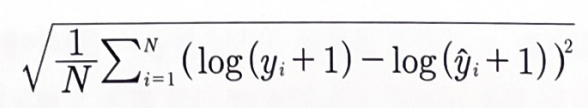

In [73]:
from IPython.display import Image
Image('/content/drive/MyDrive/ASAC/Python 머신러닝/img/ml_rmsle_식.png')
# +1은 로그처리 때문에 보정된 값이다

In [75]:
# 평가함수를 커스텀으로 구성하여 체킹
from sklearn.metrics import mean_squared_log_error
import numpy as np

def my_rmsle(y_true, y_pred, transfer = True):
    '''
        정답이나, 예측값이 로그로 변환된 값이면, 일단 복원 후 RMSLE로 태워서 평가한다
        Parameters:
            - y_true : 실제값
            - y_pred : 예측값
            - transfer : 로그 변환된 타겟값으로 학습, 예측했다면, 원복 작업 필요
                - True : np.exp() 함수로 복원

    '''
    if transfer :
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)

    log_y_true = np.nan_to_num(np.log(y_true + 1)) # 로그 변환 후 결측시 0으로 보정
    log_y_pred = np.nan_to_num(np.log(y_pred + 1)) # 로그 변환 후 결측시 0으로 보정

    # RMSLE 계산
    # mean_squared_log_error
    return np.sqrt(np.mean((log_y_true - log_y_pred)**2))


# [3] 베이스라인 구축 - 제출(레벨 검증단계)

In [76]:
from sklearn.linear_model import LinearRegression

lr_reg = LinearRegression()

lr_reg.fit(X_train, log_y)

pred_y = lr_reg.predict(X_test)

my_rmsle(np.log(y_test), pred_y)

1.0113716342195682

In [78]:
# 제출
sub_y_pred = lr_reg.predict(X_sub)
submission['count'] = np.exp(sub_y_pred) # 복원
submission.to_csv('submission_v1.csv', index = False)

# 케글 제출후 점수 확인 => 최적화 진입

#[4] 최적화 - 기본모델업그레이드, 파이캐럿(AutoML)사용
- https://www.kaggle.com/competitions/bike-sharing-demand/leaderboard
- 베이스 모델
    - 1.02249점 정도, 1등은 0.3에 수렴한다


## 모델 1개에 대해서 하이퍼파라미터 튜닝, 교차검증


In [79]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# make_scorer()을 이용하여 커스텀으로 만든 함수를 스코어링에 활용

lasso = Lasso()
param_grid = {
    'alpha':[0.01, 0.1, 1, 2, 4, 8, 10, 100],
    'max_iter':[1000,2000,3000]
}

# greater_is_better = False : True(분류, 값이 커지면 좋다), False(회귀, 값이 작아지면 좋다(손실함수기준))
my_rmsle_scorer = make_scorer(my_rmsle, greater_is_better = False)
grid = GridSearchCV(lasso, param_grid, scoring = my_rmsle_scorer, cv = 5)

# 학습
grid.fit(X_train, log_y)

# 베스트
grid.best_params_, grid.best_score_

# 점수가 음수로 나옴

({'alpha': 0.01, 'max_iter': 1000}, -1.0262369700250573)

In [80]:
y_pred = grid.best_estimator_.predict(X_sub)
submission['count'] = np.exp(sub_y_pred)
submission.to_csv('submission_lasso_v1.csv', index = False)
# 1.021 정도, 약간 개선은 된듯?

## 앙상블 모델 1개에 대해서 하이퍼파라미터 튜닝, 교차검증

In [81]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()
param_grid = {
    'n_estimators' : [100,120,140],
    'random_state' : [0,20,42]
}
grid = GridSearchCV(rf_reg, param_grid, scoring = my_rmsle_scorer, cv = 5)
grid.fit(X_train, log_y)

grid.best_params_, grid.best_score_

({'n_estimators': 140, 'random_state': 20}, -0.3219083573166034)

In [84]:
sub_y_pred = grid.best_estimator_.predict( X_sub )
submission['count'] =  np.exp( sub_y_pred ) # 복원
submission.to_csv('submission_rf_reg_v1.csv', index=False)
# 1.02249 => 1.02118  => 0.40476 (262등)

- 메달 기준

|--|0-99팀|100-249팀|250-999팀|1000팀이상|
|--|--|--|--|--|
|금|상위 10%|상위 1위|상위 10위+0.2%|상위 10위+0.2%|
|은|상위 20%|상위 20%|상위 50위|상위 5%|
|동|상위 40%|상위 40%|상위 100위|상위 10%|

## 파이캐럿

In [85]:
!pip install -q catboost
!pip install --upgrade -g -xgboost
!pip install -q pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.5 MB/s eta 0:00:00

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -g
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.9/483.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4

### 데이터 준비

In [87]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
X.shape, y.shape

((10885, 9), (10885,))

### 후보 알고리즘

In [88]:
from pycaret.regression import *

### setup

In [90]:
reg = setup(
    data = X, # 피처 데이터
    target = np.log(y), # 타겟 데이터
    verbose = True,
    train_size = 0.9,
    data_split_shuffle = True,
    normalize = True,
    session_id = 100
            )

,Description,Value
0,Session id,100
1,Target,count
2,Target type,Regression
3,Original data shape,"(10885, 10)"
4,Transformed data shape,"(10885, 33)"
5,Transformed train set shape,"(9796, 33)"
6,Transformed test set shape,"(1089, 33)"
7,Numeric features,8
8,Categorical features,1
9,Preprocess,True


In [91]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


### top6 후보군(숫자는 조정)

In [92]:
top6_model = compare_models(fold = 5, round = 3, n_select = 6, errors ='ignore')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.213,0.108,0.328,0.952,0.112,0.071,1.426
lightgbm,Light Gradient Boosting Machine,0.237,0.123,0.351,0.945,0.116,0.077,0.770
xgboost,Extreme Gradient Boosting,0.238,0.130,0.360,0.941,0.120,0.079,1.028
rf,Random Forest Regressor,0.241,0.137,0.369,0.938,0.122,0.080,2.456
et,Extra Trees Regressor,0.242,0.143,0.378,0.936,0.127,0.082,2.036
knn,K Neighbors Regressor,0.267,0.165,0.406,0.926,0.126,0.087,0.136
gbr,Gradient Boosting Regressor,0.378,0.256,0.506,0.885,0.144,0.114,0.508
dt,Decision Tree Regressor,0.322,0.260,0.510,0.883,0.165,0.107,0.092
lar,Least Angle Regression,0.474,0.409,0.639,0.816,0.174,0.147,0.072
lr,Linear Regression,0.474,0.409,0.639,0.816,0.174,0.147,1.426


Processing:   0%|          | 0/90 [00:00<?, ?it/s]

### 개별 알고리즘 확인


In [93]:
top6_model

 LGBMRegressor(n_jobs=-1, random_state=100),
 XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=100, ...),
 RandomForestRegressor(n_jobs=-1, random_state=100),
 ExtraTreesRegressor(n_jobs=-1, random_state=100),
 KNeighborsRegressor(n_jobs=-1)]

### 블랜딩

In [94]:
reg_blended = blend_models(estimator_list = top6_model, fold = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2138,0.1051,0.3241,0.9524,0.1076,0.0699
1,0.1986,0.0928,0.3046,0.9550,0.1049,0.0634
2,0.2150,0.1106,0.3326,0.9480,0.1131,0.0685
3,0.2203,0.1175,0.3428,0.9505,0.1159,0.0793
4,0.2231,0.1324,0.3638,0.9417,0.1286,0.0692
5,0.2105,0.1030,0.3210,0.9488,0.1039,0.0674
6,0.2271,0.1263,0.3554,0.9455,0.1156,0.0834
7,0.2276,0.1232,0.3510,0.9493,0.1293,0.0791
8,0.2142,0.1037,0.3220,0.9530,0.1072,0.0728


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### 최종모델 도출

In [95]:
model = finalize_model(reg_blended)
model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['season', 'holiday', 'workingday',
                                             'weather', 'temp', 'humidity',
                                             'year', 'weekday'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['hour'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('onehot_encoding',
                 TransformerWrapp...
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           n_estimators=100,
                                                           n_jobs=-1,
                                                           num_parallel_tree=None,
                                                           predictor=None,
                                                           random_state=100, ...)),
                                             ('Random Forest Regressor',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=100)),
                                             ('Extra Trees Regressor',
                                              ExtraTreesRegressor(n_jobs=-1,
                                                                  random_state=100)),
                                             ('K Neighbors Regressor',
                                              KNeighborsRegressor(n_jobs=-1))],
                                 n_jobs=-1))])

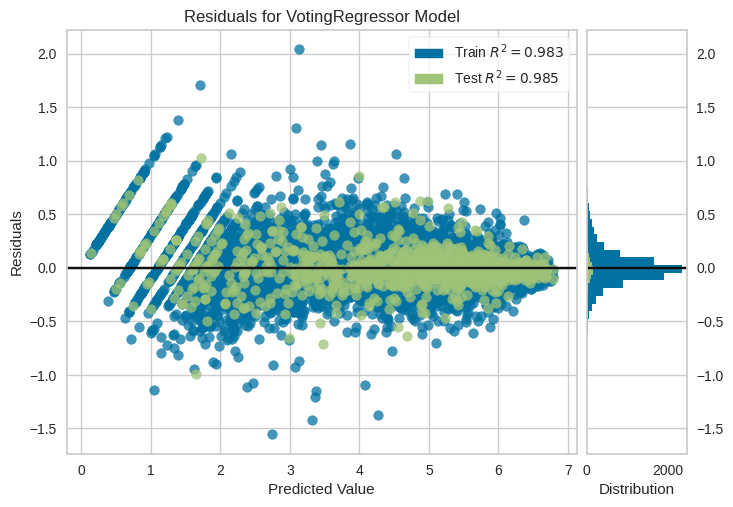

In [96]:
# 모델 시각화
plot_model(model)

In [97]:
# 검증 데이터 결과
predict_model(model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.1234,0.0330,0.1817,0.9848,0.0614,0.0421


,season,holiday,workingday,weather,temp,humidity,year,hour,weekday,count,prediction_label
7937,2,0,1,1,26.240000,78,1,03,0,1.791759,1.766822
2245,2,0,1,2,33.619999,59,0,11,2,4.718499,4.868709
7731,2,0,0,1,25.420000,41,1,13,5,6.520621,6.484995
436,1,0,1,3,5.740000,93,0,06,1,3.091043,3.085785
4443,4,0,1,1,21.320000,59,0,04,0,1.609438,1.679418
...,...,...,...,...,...,...,...,...,...,...,...
4960,4,0,0,1,15.580000,46,0,18,5,5.337538,5.394132
10536,4,0,1,1,18.040001,44,1,11,2,5.147494,5.332248
10506,4,0,1,2,18.040001,88,1,05,1,3.828641,3.607544
5264,4,0,1,1,12.300000,52,0,10,1,4.624973,4.707484


### 제출

In [98]:
sub_y_pred = predict_model(model, data = X_sub)
submission['count'] =  np.exp( sub_y_pred.prediction_label.values ) # 복원
submission.to_csv('submission_pycaret_v1.csv', index=False)
# 0.37803